In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from lorenz63 import solve_l63_rk4
sys.path.append('../')
from esn.utils import errors
from esn.validation import validate
from esn.esn import ESN

# Generate the data:
Solve the Lorenz 63 system using RK4. The parameters and inital condition are selected to ensure the system is chaotic. 

In [3]:
dim = 3
# Parameters to ensure the system is chaotic
params = [2.667, 28, 10]  # beta, rho, sigma
u0 = np.array([0.0, 1.0, 1.0])  # initial condition

dt = 0.01  # time step
t_lyap = 0.9**(-1)  # Lyapunov time

N_lyap = int(t_lyap/dt)
N_trans = 2000  # initial transient to discard
N_total = 500*N_lyap + N_trans
time_array, U_rk4, derU = solve_l63_rk4(N_total, dt, u0=u0, params=params)
U_rk4 = U_rk4[N_trans:]  # remove the initial transient

Prepare the training, validation and test data. Allow for a washout phase in the reservoir. 

In [4]:
# set sizes
washout_size = 100
train_size = 10000
val_size = 5000
test_washout_size = 100

# Extract the shape of the original data
total_samples, num_features = U_rk4.shape

# Split the data into different datasets
U_washout = U_rk4[:washout_size, :]
U_train_input = U_rk4[washout_size:washout_size + train_size, :]
U_train_label = U_rk4[washout_size + 1: washout_size + train_size + 1, :]
U_val_input = U_rk4[washout_size + train_size: washout_size + train_size + val_size, :]
U_val_label = U_rk4[washout_size + train_size + 1: washout_size + train_size + val_size + 1, :]
U_test_washout = U_rk4[washout_size + train_size + val_size:washout_size + train_size + val_size + test_washout_size, :]
U_test = U_rk4[washout_size + train_size + val_size + test_washout_size:, :]

# Print shapes of datasets
print(f"Training data shape: {U_train_input.shape}")
print(f"U_val shape: {U_val_input.shape}")
print(f"U_test shape: {U_test.shape}")

Training data shape: (10000, 3)
U_val shape: (5000, 3)
U_test shape: (40301, 3)


# Training and Validation of ESNs

In [5]:
# range for hyperparameters (spectral radius and input scaling)
spec_in = 0.25
spec_end = 1.0
in_scal_in = np.log10(0.1)
in_scal_end = np.log10(10.0)
leak_in = 1.0
leak_end = 1.0
grid_range = [[spec_in, spec_end], [in_scal_in, in_scal_end], [leak_in, leak_end]]
# In case we want to start from a grid_search,
# the first n_grid_x*n_grid_y points are from grid search
param_names = ['spectral_radius', 'input_scaling']  # ,'leak_factor']
param_scales = ['uniform', 'log10', 'uniform']
n_grid = [4, 4, 4, 4]
N_washout = 40
N_val = 50
ESN_dict = {'reservoir_size': 100,
            'dimension': dim,
            'reservoir_connectivity': 3,
            'input_normalization': None}
min_dict = validate(
    grid_range=grid_range, param_names=param_names, param_scales=param_scales, n_calls=20, n_initial_points=2,
    ESN_dict=ESN_dict, U_washout_train=U_washout, tikh=1e-6, n_realisations=5, U_train=U_train_input,
    Y_train=U_train_label, U_val=[U_val_input],
    Y_val=[U_val_label],
    n_folds=1, N_washout_steps=N_washout, N_val_steps=N_val, N_transient_steps=10, ESN_type="standard", random_seed=20,
    error_measure=errors.rmse)

Input to run_gp:([Real(low=0.25, high=1.0, prior='uniform', transform='identity'), Real(low=-1.0, high=1.0, prior='uniform', transform='identity')], 20, 2, 20)
--NEW RUN-- 1
Realisation: 0
spectral_radius 0.6946334636687639
input_scaling 4.881255012149711


Val regime: 0
Fold: 0 , fold error:  8.18147448453335
Val regime error: 8.18147448453335
Realisation error: 8.18147448453335


Realisation: 1
spectral_radius 0.6946334636687639
input_scaling 4.881255012149711


Val regime: 0
Fold: 0 , fold error:  11.247736741840578
Val regime error: 11.247736741840578
Realisation error: 11.247736741840578


Realisation: 2
spectral_radius 0.6946334636687639
input_scaling 4.881255012149711


Val regime: 0
Fold: 0 , fold error:  14.46876295144253
Val regime error: 14.46876295144253
Realisation error: 14.46876295144253


Realisation: 3
spectral_radius 0.6946334636687639
input_scaling 4.881255012149711


Val regime: 0
Fold: 0 , fold error:  28.94507632197855
Val regime error: 28.94507632197855
Realisati

# Train the ESN with the best hyperparameter and predict on the test set

In [8]:
my_ESN = ESN(reservoir_size=100,
             dimension=dim,
             reservoir_connectivity=3,
             spectral_radius=min_dict['spectral_radius'][0],
             input_scaling=min_dict['input_scaling'][0],
             leak_factor=1.0,
             input_normalization=None,
             r2_mode=False,
             input_seeds=[0, 1, 2],
             reservoir_seeds=[3, 4])

my_ESN.train(U_washout, U_train_input, U_train_label, tikhonov=1e-6)
reservoir, prediction = my_ESN.closed_loop_with_washout(U_test_washout, 5000)

Input normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Spectral radius is set to 1, set it separately if necessary.
Reservoir weights are rescaled with the new spectral radius.


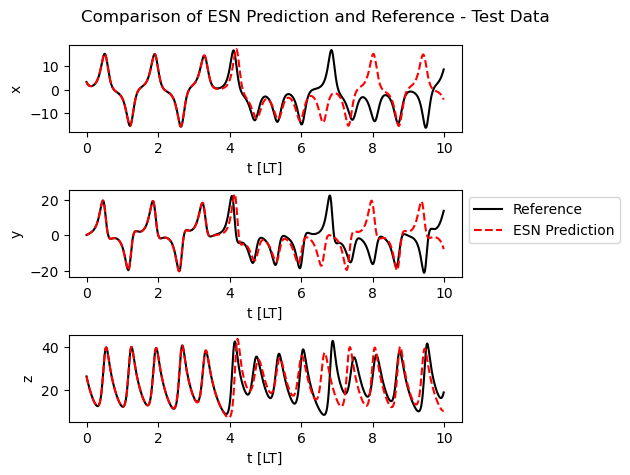

In [9]:
N_plot = 10 * N_lyap
# Define time steps
time_steps = np.arange(0, N_plot * dt, dt) / t_lyap

# Create a figure with three subplots
fig, axes = plt.subplots(3, 1)

# Plot U_test for the first feature
axes[0].plot(time_steps[:N_plot], U_test[:N_plot, 0], color='black', label='Reference')
axes[0].plot(time_steps[:N_plot], prediction[:N_plot, 0], color='red', linestyle='dashed', label='ESN Prediction')
axes[0].set_ylabel("x")
axes[0].set_xlabel("t [LT]")

# Plot U_test for the second feature
axes[1].plot(time_steps, U_test[:N_plot, 1], color='black', label='Reference')
axes[1].plot(time_steps, prediction[:N_plot, 1], color='red', linestyle='dashed', label='ESN Prediction')
axes[1].set_ylabel("y")
axes[1].set_xlabel("t [LT]")
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Plot prediction and U_test for the third feature
axes[2].plot(time_steps[:N_plot], U_test[:N_plot, 2], color='black', label='Reference')
axes[2].plot(time_steps[:N_plot], prediction[:N_plot, 2], color='red', linestyle='dashed', label='ESN Prediction')
axes[2].set_ylabel("z")
axes[2].set_xlabel("t [LT]")

# Add a title for the entire figure
fig.suptitle("Comparison of ESN Prediction and Reference - Test Data")
# Adjust layout for better spacing
plt.tight_layout()
# Show the plot
plt.show()